In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from typing import Tuple, List, Dict, Any

In [3]:
class EnhancedMomentumGradientDescent:    
    def __init__(self, learning_rate: float = 0.01, momentum: float = 0.9, 
                 max_iterations: int = 2000, tolerance: float = 1e-5, track_metrics: bool = True):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.track_metrics = track_metrics
        
        # Tracking metrics for empirical analysis
        self.cost_history = []
        self.gradient_norms = []
        self.weight_history = []
        self.velocity_history = []
        self.convergence_info = {}
        
    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Stable sigmoid function"""
        return np.where(z >= 0, 
                       1 / (1 + np.exp(-z)),
                       np.exp(z) / (1 + np.exp(z)))
    
    def compute_cost_and_gradients(self, X: np.ndarray, y: np.ndarray, 
                                  weights: np.ndarray, problem_type: str) -> Tuple[float, np.ndarray]:
        """
        Compute cost and gradients for different problem types
        
        Args:
            X: Feature matrix (m x n)
            y: Target values (m,)
            weights: Current weights (n,)
            problem_type: 'regression', 'classification', 'non_convex'
        
        Returns:
            cost: Current cost value
            gradients: Gradient vector
        """
        m = X.shape[0]
        
        if problem_type == 'regression':
            # Linear regression (convex)
            predictions = X @ weights
            cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
            gradients = (1 / m) * X.T @ (predictions - y)
            
        elif problem_type == 'classification':
            # Logistic regression (convex)
            z = X @ weights
            predictions = self.sigmoid(z)
            # Add small epsilon to prevent log(0)
            epsilon = 1e-15
            predictions = np.clip(predictions, epsilon, 1 - epsilon)
            
            cost = -(1 / m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
            gradients = (1 / m) * X.T @ (predictions - y)
            
        elif problem_type == 'non_convex':
            # Non-convex function: Rosenbrock-like function
            cost = 0
            gradients = np.zeros_like(weights)
            
            for i in range(len(weights) - 1):
                cost += (weights[i+1] - weights[i]**2)**2 + 0.01 * (1 - weights[i])**2
                
                # Gradients for non-convex function
                gradients[i] += -4 * weights[i] * (weights[i+1] - weights[i]**2) - 0.02 * (1 - weights[i])
                gradients[i+1] += 2 * (weights[i+1] - weights[i]**2)
        
        return cost, gradients
    
    def add_gradient_noise(self, gradients: np.ndarray, noise_level: float = 0.01) -> np.ndarray:
        """Add noise to gradients for robustness analysis"""
        if noise_level > 0:
            noise = np.random.normal(0, noise_level, gradients.shape)
            return gradients + noise
        return gradients
    
    def fit(self, X: np.ndarray, y: np.ndarray, problem_type: str = 'classification', 
            noise_level: float = 0.0) -> Dict[str, Any]:
        """
        Fit the model using momentum-based gradient descent
        
        Args:
            X: Feature matrix
            y: Target values
            problem_type: 'regression', 'classification', 'non_convex'
            noise_level: Amount of noise to add to gradients
            
        Returns:
            Dictionary with training results and analysis
        """
        # Initialize weights and momentum
        n_features = X.shape[1]
        weights = np.random.normal(0, 0.1, n_features)
        velocity = np.zeros_like(weights)  # Initialize momentum velocity
        
        # Reset tracking
        self.cost_history = []
        self.gradient_norms = []
        self.weight_history = []
        self.velocity_history = []
        
        prev_cost = float('inf')
        
        for iteration in range(self.max_iterations):
            # Compute cost and gradients
            cost, gradients = self.compute_cost_and_gradients(X, y, weights, problem_type)
            
            # Add noise if specified (for gradient noise analysis)
            if noise_level > 0:
                gradients = self.add_gradient_noise(gradients, noise_level)
            
            # Momentum update (key difference from vanilla GD)
            velocity = self.momentum * velocity + self.learning_rate * gradients
            weights = weights - velocity
            
            # Track metrics for empirical analysis
            if self.track_metrics:
                self.cost_history.append(cost)
                self.gradient_norms.append(np.linalg.norm(gradients))
                self.weight_history.append(weights.copy())
                self.velocity_history.append(velocity.copy())
            
            # Check for convergence (multiple criteria)
            cost_change = abs(prev_cost - cost)
            gradient_norm = np.linalg.norm(gradients)
            velocity_norm = np.linalg.norm(velocity)
            
            # Problem-specific convergence criteria
            if problem_type == 'classification':
                converged = (cost_change < max(self.tolerance * 10, 1e-5) or 
                           gradient_norm < max(self.tolerance * 100, 1e-4) or
                           velocity_norm < 1e-5)
            elif problem_type == 'regression':
                converged = (cost_change < self.tolerance or 
                           gradient_norm < self.tolerance * 10 or
                           velocity_norm < 1e-6)
            else:  # non_convex
                converged = (cost_change < self.tolerance * 5 or 
                           gradient_norm < self.tolerance * 50)
            
            if converged:
                self.convergence_info = {
                    'converged': True,
                    'iterations': iteration + 1,
                    'final_cost': cost,
                    'gradient_norm': gradient_norm,
                    'cost_change': cost_change,
                    'velocity_norm': velocity_norm
                }
                break
                
            prev_cost = cost
        else:
            self.convergence_info = {
                'converged': False,
                'iterations': self.max_iterations,
                'final_cost': cost,
                'gradient_norm': np.linalg.norm(gradients),
                'cost_change': abs(prev_cost - cost),
                'velocity_norm': np.linalg.norm(velocity)
            }
        
        self.final_weights = weights
        self.final_velocity = velocity
        return self.convergence_info
    
    def predict(self, X: np.ndarray, problem_type: str = 'classification') -> np.ndarray:
        """Make predictions using trained weights"""
        if not hasattr(self, 'final_weights'):
            raise ValueError("Model must be fitted before making predictions")
            
        if problem_type == 'regression':
            return X @ self.final_weights
        elif problem_type == 'classification':
            z = X @ self.final_weights
            return self.sigmoid(z)
        else:
            return X @ self.final_weights
    
    def analyze_momentum_values(self, X: np.ndarray, y: np.ndarray, 
                               momentum_values: List[float], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of different momentum values"""
        results = {}
        
        for momentum in momentum_values:
            print(f"Testing momentum: {momentum}")
            
            # Create new instance with specific momentum
            mgd = EnhancedMomentumGradientDescent(
                learning_rate=0.01, momentum=momentum, max_iterations=2000, track_metrics=True
            )
            convergence_info = mgd.fit(X, y, problem_type)
            
            results[momentum] = {
                'convergence_info': convergence_info,
                'cost_history': mgd.cost_history.copy(),
                'gradient_norms': mgd.gradient_norms.copy(),
                'velocity_history': mgd.velocity_history.copy(),
                'final_weights': mgd.final_weights.copy()
            }
        
        return results
    
    def analyze_learning_rates(self, X: np.ndarray, y: np.ndarray, 
                              learning_rates: List[float], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of different learning rates with momentum"""
        results = {}
        
        for lr in learning_rates:
            print(f"Testing learning rate: {lr}")
            
            # Create new instance with specific learning rate
            mgd = EnhancedMomentumGradientDescent(
                learning_rate=lr, momentum=0.9, max_iterations=2000, track_metrics=True
            )
            convergence_info = mgd.fit(X, y, problem_type)
            
            results[lr] = {
                'convergence_info': convergence_info,
                'cost_history': mgd.cost_history.copy(),
                'gradient_norms': mgd.gradient_norms.copy(),
                'velocity_history': mgd.velocity_history.copy(),
                'final_weights': mgd.final_weights.copy()
            }
        
        return results
    
    def analyze_gradient_noise(self, X: np.ndarray, y: np.ndarray, 
                              noise_levels: List[float], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of gradient noise effects with momentum"""
        results = {}
        
        for noise in noise_levels:
            print(f"Testing noise level: {noise}")
            
            mgd = EnhancedMomentumGradientDescent(
                learning_rate=0.01, momentum=0.9, max_iterations=2000, track_metrics=True
            )
            convergence_info = mgd.fit(X, y, problem_type, noise_level=noise)
            
            results[noise] = {
                'convergence_info': convergence_info,
                'cost_history': mgd.cost_history.copy(),
                'gradient_norms': mgd.gradient_norms.copy(),
                'velocity_history': mgd.velocity_history.copy()
            }
        
        return results
    
    def plot_convergence_analysis(self, results: Dict, analysis_type: str = 'momentum'):
        """Plot convergence behavior for empirical analysis"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Momentum GD Convergence Analysis - {analysis_type.replace("_", " ").title()}', 
                     fontsize=16)
        
        # Plot 1: Cost vs Iterations
        ax1 = axes[0, 0]
        for param, data in results.items():
            iterations = range(len(data['cost_history']))
            ax1.plot(iterations, data['cost_history'], label=f'{analysis_type}: {param}', linewidth=2)
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Cost')
        ax1.set_title('Cost Function Convergence')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')
        
        # Plot 2: Gradient Norms
        ax2 = axes[0, 1]
        for param, data in results.items():
            iterations = range(len(data['gradient_norms']))
            ax2.plot(iterations, data['gradient_norms'], label=f'{analysis_type}: {param}', linewidth=2)
        ax2.set_xlabel('Iterations')
        ax2.set_ylabel('Gradient Norm')
        ax2.set_title('Gradient Norm Evolution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')
        
        # Plot 3: Velocity Evolution (unique to momentum)
        ax3 = axes[0, 2]
        for param, data in results.items():
            if 'velocity_history' in data and len(data['velocity_history']) > 0:
                velocity_norms = [np.linalg.norm(v) for v in data['velocity_history']]
                iterations = range(len(velocity_norms))
                ax3.plot(iterations, velocity_norms, label=f'{analysis_type}: {param}', linewidth=2)
        ax3.set_xlabel('Iterations')
        ax3.set_ylabel('Velocity Norm')
        ax3.set_title('Momentum Velocity Evolution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Final convergence comparison
        ax4 = axes[1, 0]
        params = list(results.keys())
        final_costs = [results[p]['convergence_info']['final_cost'] for p in params]
        
        bars = ax4.bar(range(len(params)), final_costs, color='lightgreen', alpha=0.7)
        ax4.set_xlabel(f'{analysis_type.replace("_", " ").title()}')
        ax4.set_ylabel('Final Cost')
        ax4.set_title('Final Cost Comparison')
        ax4.set_xticks(range(len(params)))
        ax4.set_xticklabels([str(p) for p in params], rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Plot 5: Iterations to convergence
        ax5 = axes[1, 1]
        iterations_to_converge = [results[p]['convergence_info']['iterations'] for p in params]
        bars = ax5.bar(range(len(params)), iterations_to_converge, color='lightcoral', alpha=0.7)
        ax5.set_xlabel(f'{analysis_type.replace("_", " ").title()}')
        ax5.set_ylabel('Iterations to Convergence')
        ax5.set_title('Convergence Speed Comparison')
        ax5.set_xticks(range(len(params)))
        ax5.set_xticklabels([str(p) for p in params], rotation=45)
        ax5.grid(True, alpha=0.3)
        
        # Plot 6: Momentum Effect Visualization
        ax6 = axes[1, 2]
        if analysis_type == 'momentum':
            for param, data in results.items():
                # Plot trajectory of first weight component
                if len(data.get('weight_history', [])) > 0:
                    weight_trajectory = [w[0] if len(w) > 0 else 0 for w in data['weight_history']]
                    ax6.plot(weight_trajectory, label=f'γ={param}', linewidth=2)
            ax6.set_xlabel('Weight Value (1st component)')
            ax6.set_ylabel('Iteration')
            ax6.set_title('Weight Trajectory Comparison')
            ax6.legend()
            ax6.grid(True, alpha=0.3)
        else:
            # For non-momentum analysis, show oscillation damping
            for param, data in results.items():
                if 'velocity_history' in data and len(data['velocity_history']) > 0:
                    velocity_norms = [np.linalg.norm(v) for v in data['velocity_history']]
                    ax6.plot(velocity_norms, label=f'{analysis_type}: {param}', linewidth=2)
            ax6.set_xlabel('Iterations')
            ax6.set_ylabel('Velocity Norm')
            ax6.set_title('Velocity Evolution')
            ax6.legend()
            ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compare_with_vanilla_gd(self, X: np.ndarray, y: np.ndarray, 
                               problem_type: str = 'classification') -> Dict:
        """Compare momentum GD with vanilla GD"""
        print("Comparing Momentum GD vs Vanilla GD...")
        
        # Vanilla GD (momentum = 0)
        vanilla_gd = EnhancedMomentumGradientDescent(
            learning_rate=self.learning_rate, momentum=0.0, 
            max_iterations=self.max_iterations, track_metrics=True
        )
        vanilla_results = vanilla_gd.fit(X, y, problem_type)
        
        # Momentum GD
        momentum_gd = EnhancedMomentumGradientDescent(
            learning_rate=self.learning_rate, momentum=self.momentum, 
            max_iterations=self.max_iterations, track_metrics=True
        )
        momentum_results = momentum_gd.fit(X, y, problem_type)
        
        # Comparison plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('Momentum GD vs Vanilla GD Comparison', fontsize=14)
        
        # Cost comparison
        ax1 = axes[0]
        ax1.plot(vanilla_gd.cost_history, label='Vanilla GD', linewidth=2, color='red')
        ax1.plot(momentum_gd.cost_history, label=f'Momentum GD (γ={self.momentum})', linewidth=2, color='blue')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Cost')
        ax1.set_title('Cost Convergence Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')
        
        # Gradient norms comparison
        ax2 = axes[1]
        ax2.plot(vanilla_gd.gradient_norms, label='Vanilla GD', linewidth=2, color='red')
        ax2.plot(momentum_gd.gradient_norms, label=f'Momentum GD (γ={self.momentum})', linewidth=2, color='blue')
        ax2.set_xlabel('Iterations')
        ax2.set_ylabel('Gradient Norm')
        ax2.set_title('Gradient Norm Comparison')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')
        
        # Convergence speed comparison
        ax3 = axes[2]
        methods = ['Vanilla GD', 'Momentum GD']
        iterations = [vanilla_results['iterations'], momentum_results['iterations']]
        final_costs = [vanilla_results['final_cost'], momentum_results['final_cost']]
        
        x_pos = np.arange(len(methods))
        bars1 = ax3.bar(x_pos - 0.2, iterations, 0.4, label='Iterations', color='skyblue')
        ax3_twin = ax3.twinx()
        bars2 = ax3_twin.bar(x_pos + 0.2, final_costs, 0.4, label='Final Cost', color='orange')
        
        ax3.set_xlabel('Method')
        ax3.set_ylabel('Iterations', color='blue')
        ax3_twin.set_ylabel('Final Cost', color='orange')
        ax3.set_title('Performance Comparison')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(methods)
        ax3.legend(loc='upper left')
        ax3_twin.legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'vanilla_gd': {'results': vanilla_results, 'history': vanilla_gd.cost_history},
            'momentum_gd': {'results': momentum_results, 'history': momentum_gd.cost_history}
        }

In [5]:
def demonstrate_momentum_gradient_descent():
    """Comprehensive demonstration of Momentum GD across different settings"""
    
    # Load and prepare Iris dataset
    iris = load_iris()
    
    # === CLASSIFICATION PROBLEM (Binary) ===
    print("=== BINARY CLASSIFICATION (Convex) ===")
    # Use only first two classes for binary classification
    X_class = iris.data[iris.target != 2]  # Remove class 2
    y_class = iris.target[iris.target != 2]  # Binary: 0 or 1
    
    # Add bias term and standardize
    X_class = np.column_stack([np.ones(X_class.shape[0]), X_class])  # Add bias
    scaler = StandardScaler()
    X_class[:, 1:] = scaler.fit_transform(X_class[:, 1:])  # Standardize features only
    
    # Split data
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
    )
    
    # Train on classification
    mgd_class = EnhancedMomentumGradientDescent(learning_rate=0.1, momentum=0.9, max_iterations=2000)
    conv_info_class = mgd_class.fit(X_train_c, y_train_c, problem_type='classification')
    
    # Evaluate classification
    train_pred_c = mgd_class.predict(X_train_c, 'classification')
    test_pred_c = mgd_class.predict(X_test_c, 'classification')
    train_acc = np.mean((train_pred_c > 0.5) == y_train_c)
    test_acc = np.mean((test_pred_c > 0.5) == y_test_c)
    
    print(f"Classification - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Converged: {conv_info_class['converged']}, Iterations: {conv_info_class['iterations']}")
    print(f"Final gradient norm: {conv_info_class['gradient_norm']:.6f}, Velocity norm: {conv_info_class['velocity_norm']:.6f}")
    
    # === REGRESSION PROBLEM (Convex) ===
    print("\n=== REGRESSION (Convex) ===")
    # Use petal length as target, other features as predictors
    X_reg = iris.data[:, [0, 1, 3]]  # Sepal length, width, petal width
    y_reg = iris.data[:, 2]  # Petal length
    
    # Add bias and standardize
    X_reg = np.column_stack([np.ones(X_reg.shape[0]), X_reg])
    scaler_reg = StandardScaler()
    X_reg[:, 1:] = scaler_reg.fit_transform(X_reg[:, 1:])
    y_reg = (y_reg - np.mean(y_reg)) / np.std(y_reg)  # Standardize target
    
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_reg, y_reg, test_size=0.3, random_state=42
    )
    
    # Train on regression
    mgd_reg = EnhancedMomentumGradientDescent(learning_rate=0.1, momentum=0.9, max_iterations=2000)
    conv_info_reg = mgd_reg.fit(X_train_r, y_train_r, problem_type='regression')
    
    # Evaluate regression
    train_pred_r = mgd_reg.predict(X_train_r, 'regression')
    test_pred_r = mgd_reg.predict(X_test_r, 'regression')
    train_mse = np.mean((train_pred_r - y_train_r) ** 2)
    test_mse = np.mean((test_pred_r - y_test_r) ** 2)
    
    print(f"Regression - Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"Converged: {conv_info_reg['converged']}, Iterations: {conv_info_reg['iterations']}")
    print(f"Final gradient norm: {conv_info_reg['gradient_norm']:.6f}, Velocity norm: {conv_info_reg['velocity_norm']:.6f}")
    
    # === NON-CONVEX PROBLEM ===
    print("\n=== NON-CONVEX OPTIMIZATION ===")
    # Create a small non-convex problem
    np.random.seed(42)
    X_nonconv = np.random.randn(20, 4)  # 4D non-convex problem
    y_nonconv = np.random.randn(20)     # Dummy target for non-convex function
    
    mgd_nonconv = EnhancedMomentumGradientDescent(learning_rate=0.001, momentum=0.9, max_iterations=3000)
    conv_info_nonconv = mgd_nonconv.fit(X_nonconv, y_nonconv, problem_type='non_convex')
    
    print(f"Non-convex - Final Cost: {conv_info_nonconv['final_cost']:.6f}")
    print(f"Converged: {conv_info_nonconv['converged']}, Iterations: {conv_info_nonconv['iterations']}")
    print(f"Final gradient norm: {conv_info_nonconv['gradient_norm']:.6f}")
    
    # === EMPIRICAL ANALYSIS ===
    
    # 1. Momentum Value Analysis
    print("\n=== MOMENTUM VALUE ANALYSIS ===")
    momentum_values = [0.0, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
    momentum_analysis = mgd_class.analyze_momentum_values(
        X_train_c, y_train_c, momentum_values, 'classification'
    )
    
    # 2. Learning Rate Analysis with Momentum
    print("\n=== LEARNING RATE ANALYSIS (with Momentum) ===")
    learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
    lr_analysis = mgd_class.analyze_learning_rates(
        X_train_c, y_train_c, learning_rates, 'classification'
    )
    
    # 3. Gradient Noise Analysis with Momentum
    print("\n=== GRADIENT NOISE ANALYSIS (with Momentum) ===")
    noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3]
    noise_analysis = mgd_class.analyze_gradient_noise(
        X_train_c, y_train_c, noise_levels, 'classification'
    )
    
    # === VISUALIZATION ===
    
    # Plot momentum analysis
    mgd_viz = EnhancedMomentumGradientDescent()
    mgd_viz.plot_convergence_analysis(momentum_analysis, 'momentum')
    
    # Plot learning rate analysis
    mgd_viz.plot_convergence_analysis(lr_analysis, 'learning_rate')
    
    # Plot gradient noise analysis
    mgd_viz.plot_convergence_analysis(noise_analysis, 'noise_level')
    
    # Compare with vanilla GD
    comparison = mgd_class.compare_with_vanilla_gd(X_train_c, y_train_c, 'classification')
    
    # Detailed convergence behavior analysis
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Momentum Gradient Descent: Comprehensive Analysis', fontsize=16)
    
    # Classification convergence
    ax1 = axes[0, 0]
    ax1.plot(mgd_class.cost_history, linewidth=2, color='blue')
    ax1.set_title('Classification: Cost Convergence')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Cross-Entropy Loss')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Regression convergence
    ax2 = axes[0, 1]
    ax2.plot(mgd_reg.cost_history, linewidth=2, color='green')
    ax2.set_title('Regression: Cost Convergence')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Mean Squared Error')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    # Non-convex convergence
    ax3 = axes[0, 2]
    ax3.plot(mgd_nonconv.cost_history, linewidth=2, color='red')
    ax3.set_title('Non-Convex: Cost Convergence')
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Cost')
    ax3.grid(True, alpha=0.3)
    
    # Velocity evolution comparison
    ax4 = axes[1, 0]
    velocity_norms_class = [np.linalg.norm(v) for v in mgd_class.velocity_history]
    velocity_norms_reg = [np.linalg.norm(v) for v in mgd_reg.velocity_history]
    velocity_norms_nonconv = [np.linalg.norm(v) for v in mgd_nonconv.velocity_history]
    ax4.plot(velocity_norms_class, label='Classification', linewidth=2)
    ax4.plot(velocity_norms_reg, label='Regression', linewidth=2)
    ax4.plot(velocity_norms_nonconv, label='Non-convex', linewidth=2)
    ax4.set_title('Momentum Velocity Evolution')
    ax4.set_xlabel('Iterations')
    ax4.set_ylabel('||velocity||')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')
    
    ax5 = axes[1, 1]
    weight_norms = [
        np.linalg.norm(mgd_class.final_weights) if hasattr(mgd_class, 'final_weights') else 0,
        np.linalg.norm(mgd_reg.final_weights) if hasattr(mgd_reg, 'final_weights') else 0,
        np.linalg.norm(mgd_nonconv.final_weights) if hasattr(mgd_nonconv, 'final_weights') else 0
    ]
    labels = ['Classification', 'Regression', 'Non-Convex']
    ax5.bar(range(len(labels)), weight_norms, alpha=0.7)
    ax5.set_xticks(range(len(labels)))
    ax5.set_xticklabels(labels, rotation=45)
    ax5.set_title('Final Weight Vector Norms')
    ax5.set_ylabel('||weights||')
    ax5.grid(True, alpha=0.3)

    # Plot 6: Classification train vs test accuracy
    ax6 = axes[1, 2]
    accuracies = [train_acc, test_acc]
    acc_labels = ['Train Acc', 'Test Acc']
    ax6.bar(range(len(acc_labels)), accuracies, alpha=0.8)
    ax6.set_xticks(range(len(acc_labels)))
    ax6.set_xticklabels(acc_labels)
    ax6.set_ylim(0, 1)
    ax6.set_title('Classification Accuracy')
    for i, v in enumerate(accuracies):
        ax6.text(i, v + 0.02, f"{v:.3f}", ha='center')
    ax6.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Final summary printout
    print("\n=== SUMMARY ===")
    print("Classification:")
    print(f"  - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"  - Converged: {conv_info_class['converged']}, Iterations: {conv_info_class['iterations']}")
    print("Regression:")
    print(f"  - Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"  - Converged: {conv_info_reg['converged']}, Iterations: {conv_info_reg['iterations']}")
    print("Non-Convex:")
    print(f"  - Final Cost: {conv_info_nonconv['final_cost']:.6f}")
    print(f"  - Converged: {conv_info_nonconv['converged']}, Iterations: {conv_info_nonconv['iterations']}")

    # Return a compact results dictionary for programmatic use if needed
    return {
        'classification': {
            'train_acc': train_acc, 'test_acc': test_acc, 'conv_info': conv_info_class,
            'cost_history': mgd_class.cost_history, 'velocity_history': mgd_class.velocity_history
        },
        'regression': {
            'train_mse': train_mse, 'test_mse': test_mse, 'conv_info': conv_info_reg,
            'cost_history': mgd_reg.cost_history, 'velocity_history': mgd_reg.velocity_history
        },
        'non_convex': {
            'final_cost': conv_info_nonconv['final_cost'], 'conv_info': conv_info_nonconv,
            'cost_history': mgd_nonconv.cost_history, 'velocity_history': mgd_nonconv.velocity_history
        },
        'analyses': {
            'momentum_analysis': momentum_analysis,
            'learning_rate_analysis': lr_analysis,
            'noise_analysis': noise_analysis,
            'vanilla_vs_momentum': comparison
        }
    }

=== BINARY CLASSIFICATION (Convex) ===
Classification - Train Accuracy: 1.0000, Test Accuracy: 1.0000
Converged: True, Iterations: 37
Final gradient norm: 0.005212, Velocity norm: 0.018380

=== REGRESSION (Convex) ===
Regression - Train MSE: 0.031176, Test MSE: 0.034174
Converged: True, Iterations: 73
Final gradient norm: 0.020993, Velocity norm: 0.002767

=== NON-CONVEX OPTIMIZATION ===
Non-convex - Final Cost: 0.032800
Converged: True, Iterations: 65
Final gradient norm: 0.060642

=== MOMENTUM VALUE ANALYSIS ===
Testing momentum: 0.0
Testing momentum: 0.3
Testing momentum: 0.5
Testing momentum: 0.7
Testing momentum: 0.9
Testing momentum: 0.95
Testing momentum: 0.99

=== LEARNING RATE ANALYSIS (with Momentum) ===
Testing learning rate: 0.001
Testing learning rate: 0.01
Testing learning rate: 0.05
Testing learning rate: 0.1
Testing learning rate: 0.2
Testing learning rate: 0.5

=== GRADIENT NOISE ANALYSIS (with Momentum) ===
Testing noise level: 0.0
Testing noise level: 0.01
Testing no

C:\Users\dhani\AppData\Local\Temp\ipykernel_21384\3257886406.py:329: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax6.legend()


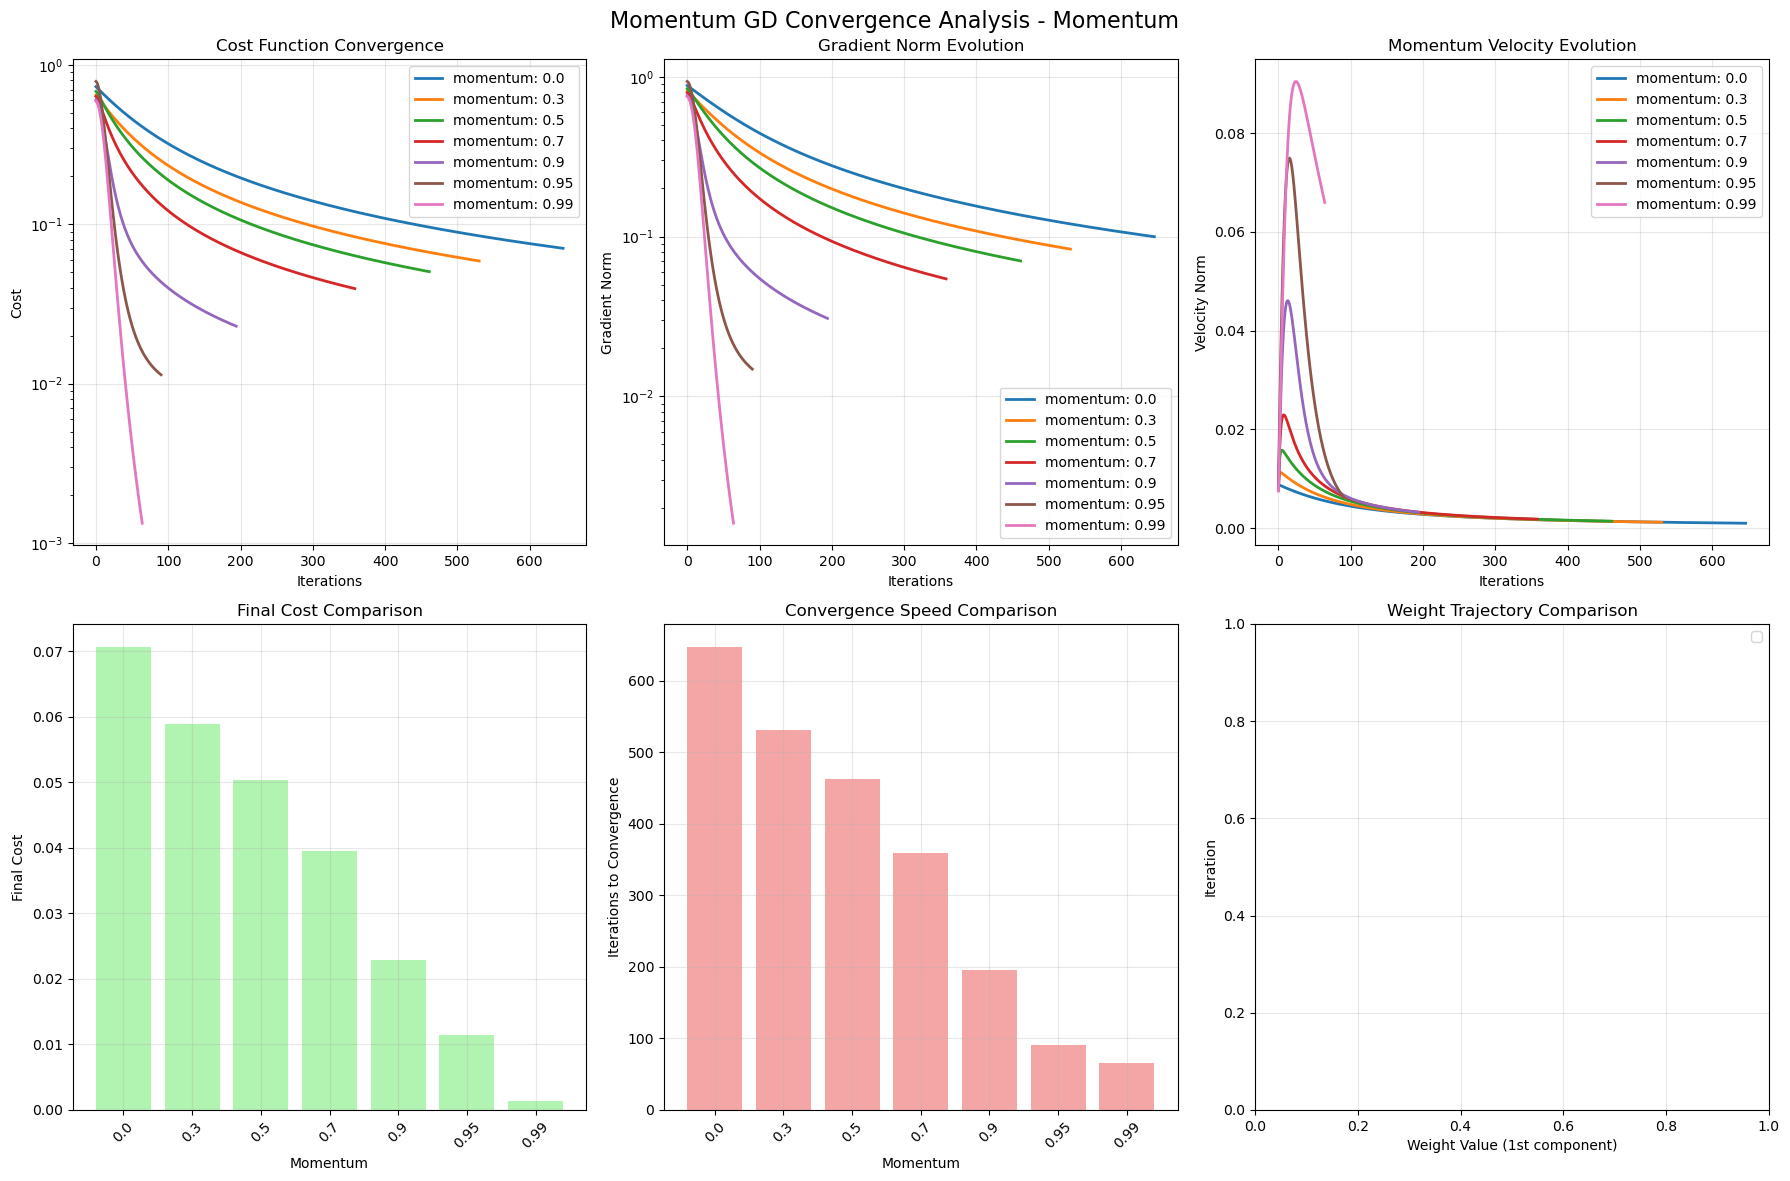

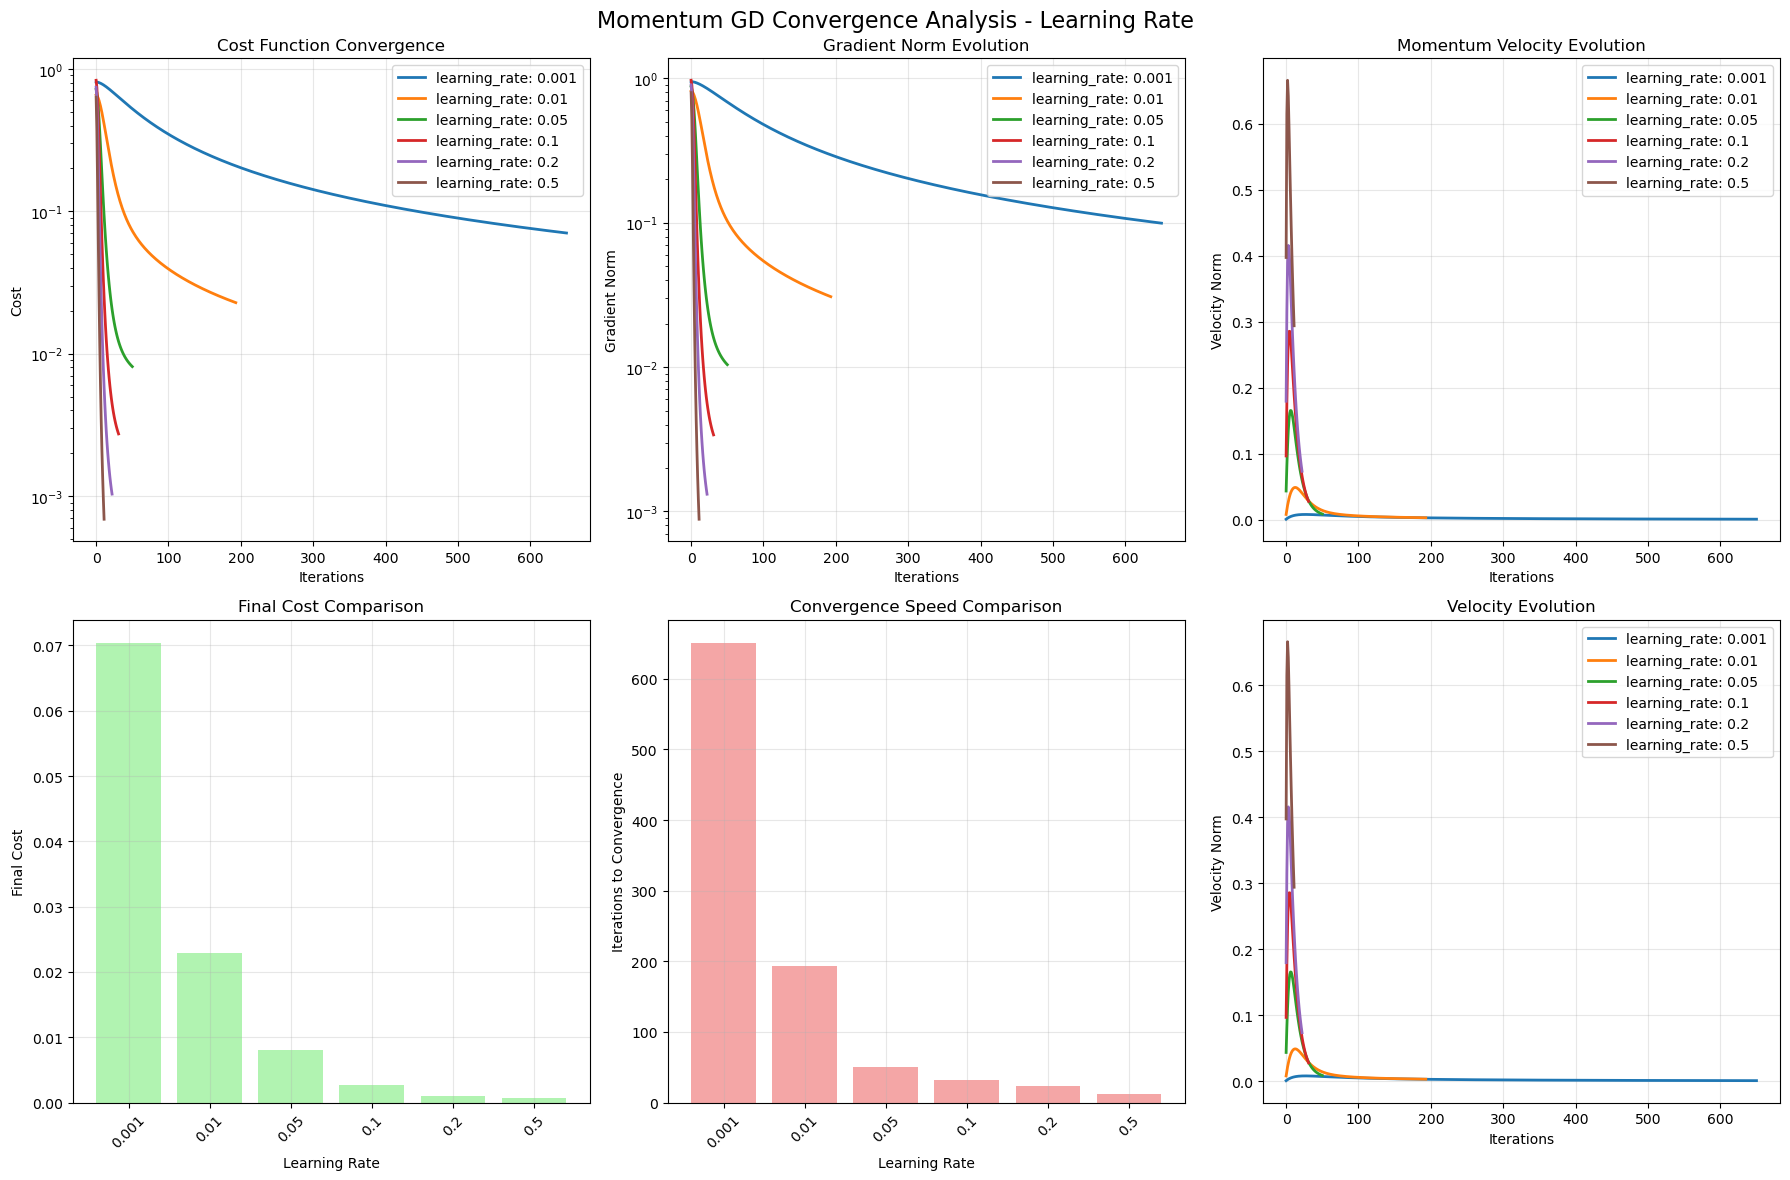

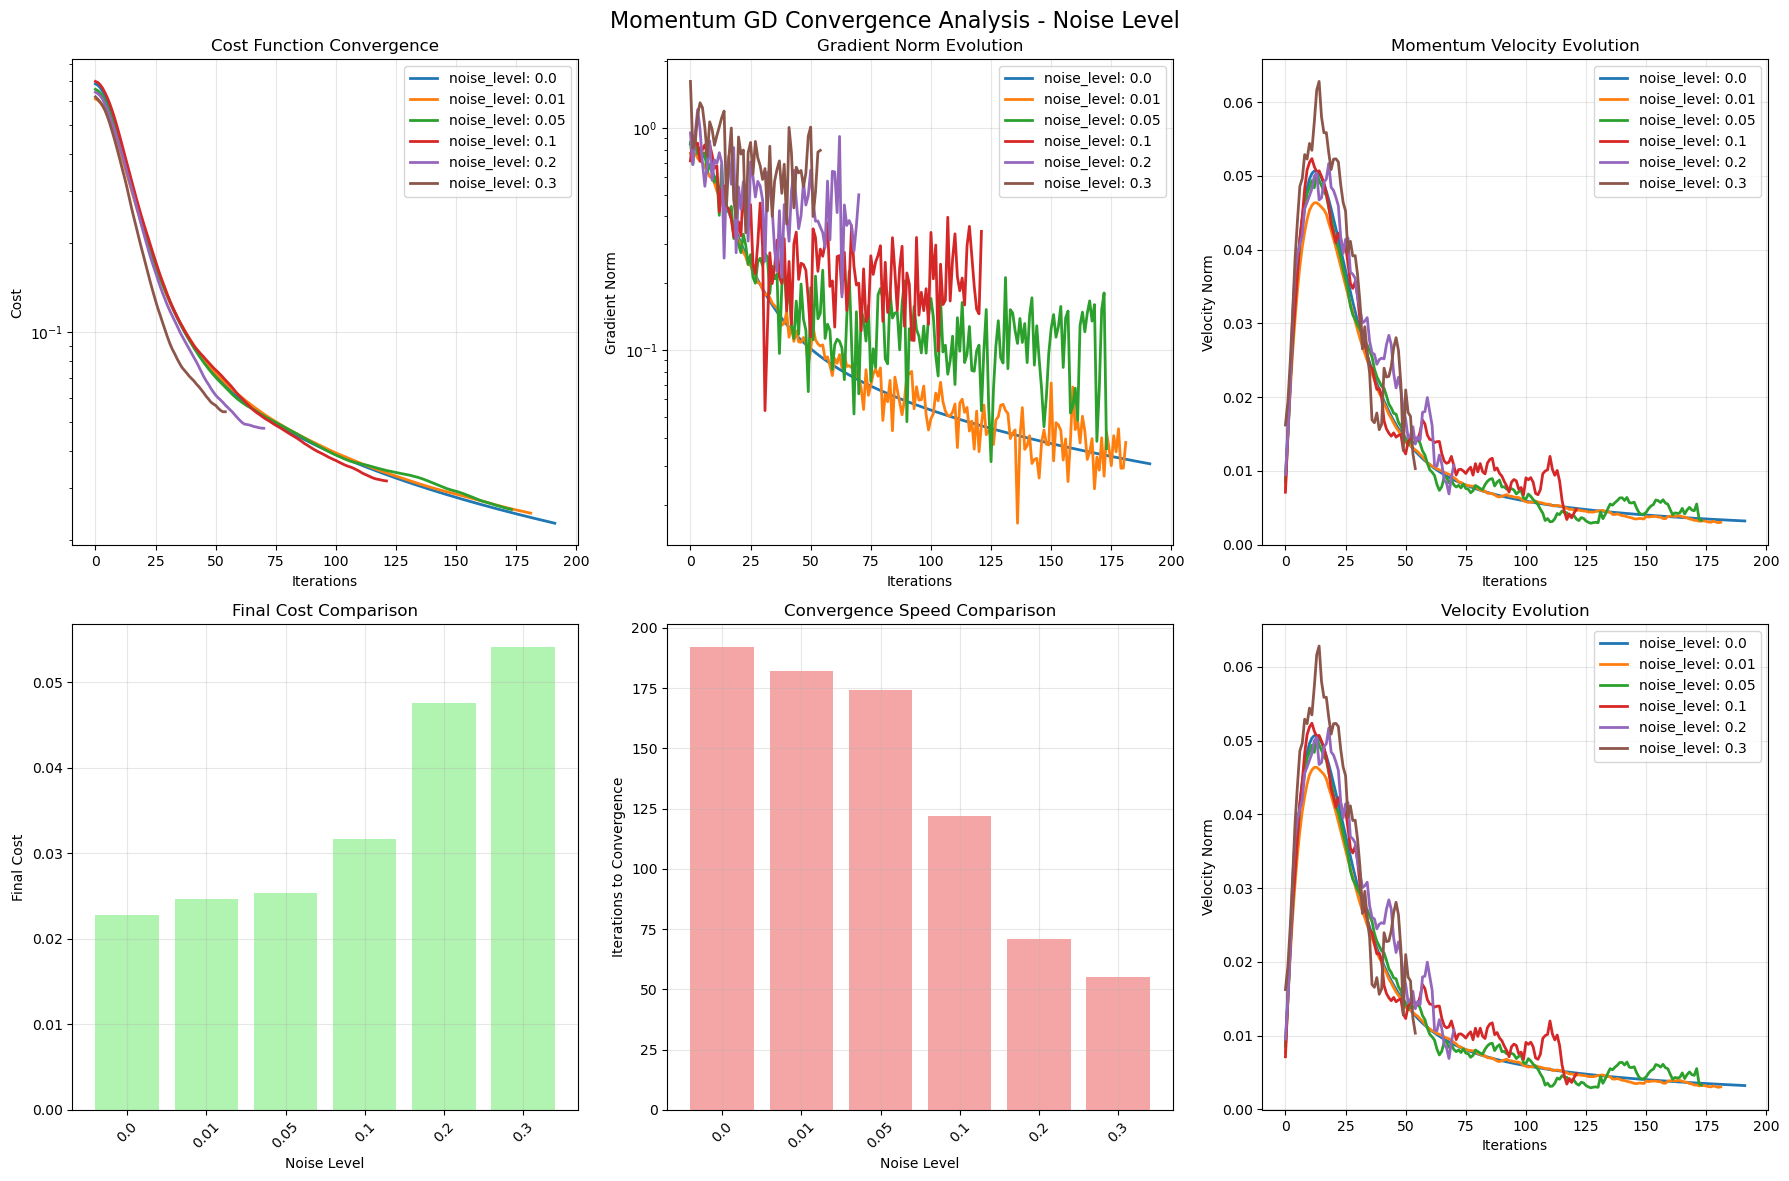

Comparing Momentum GD vs Vanilla GD...


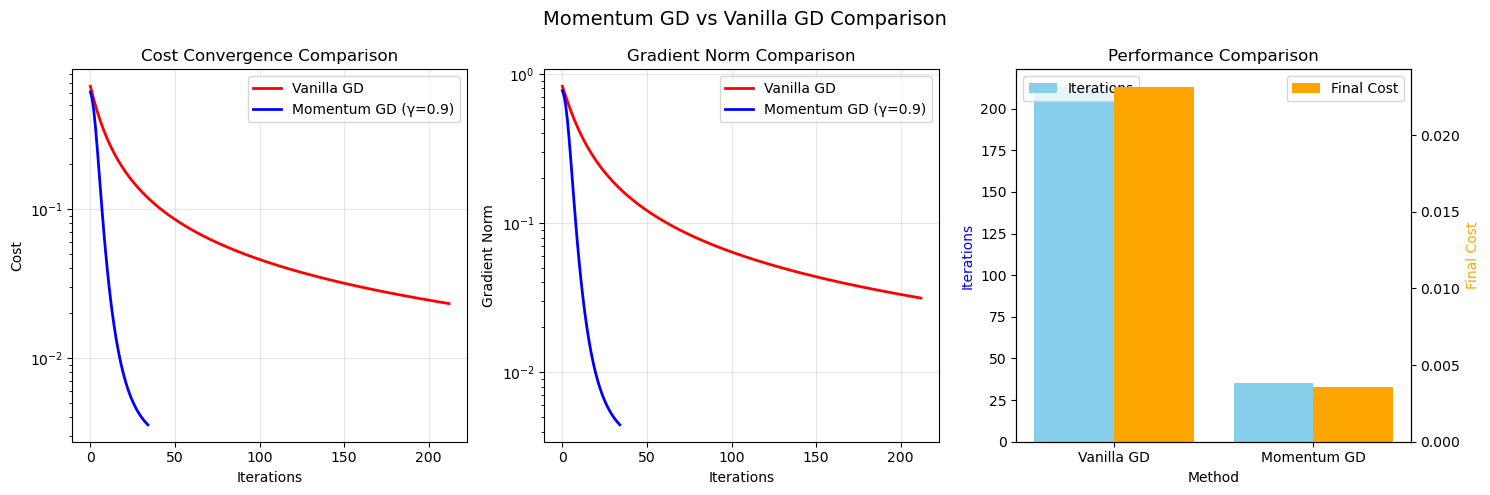

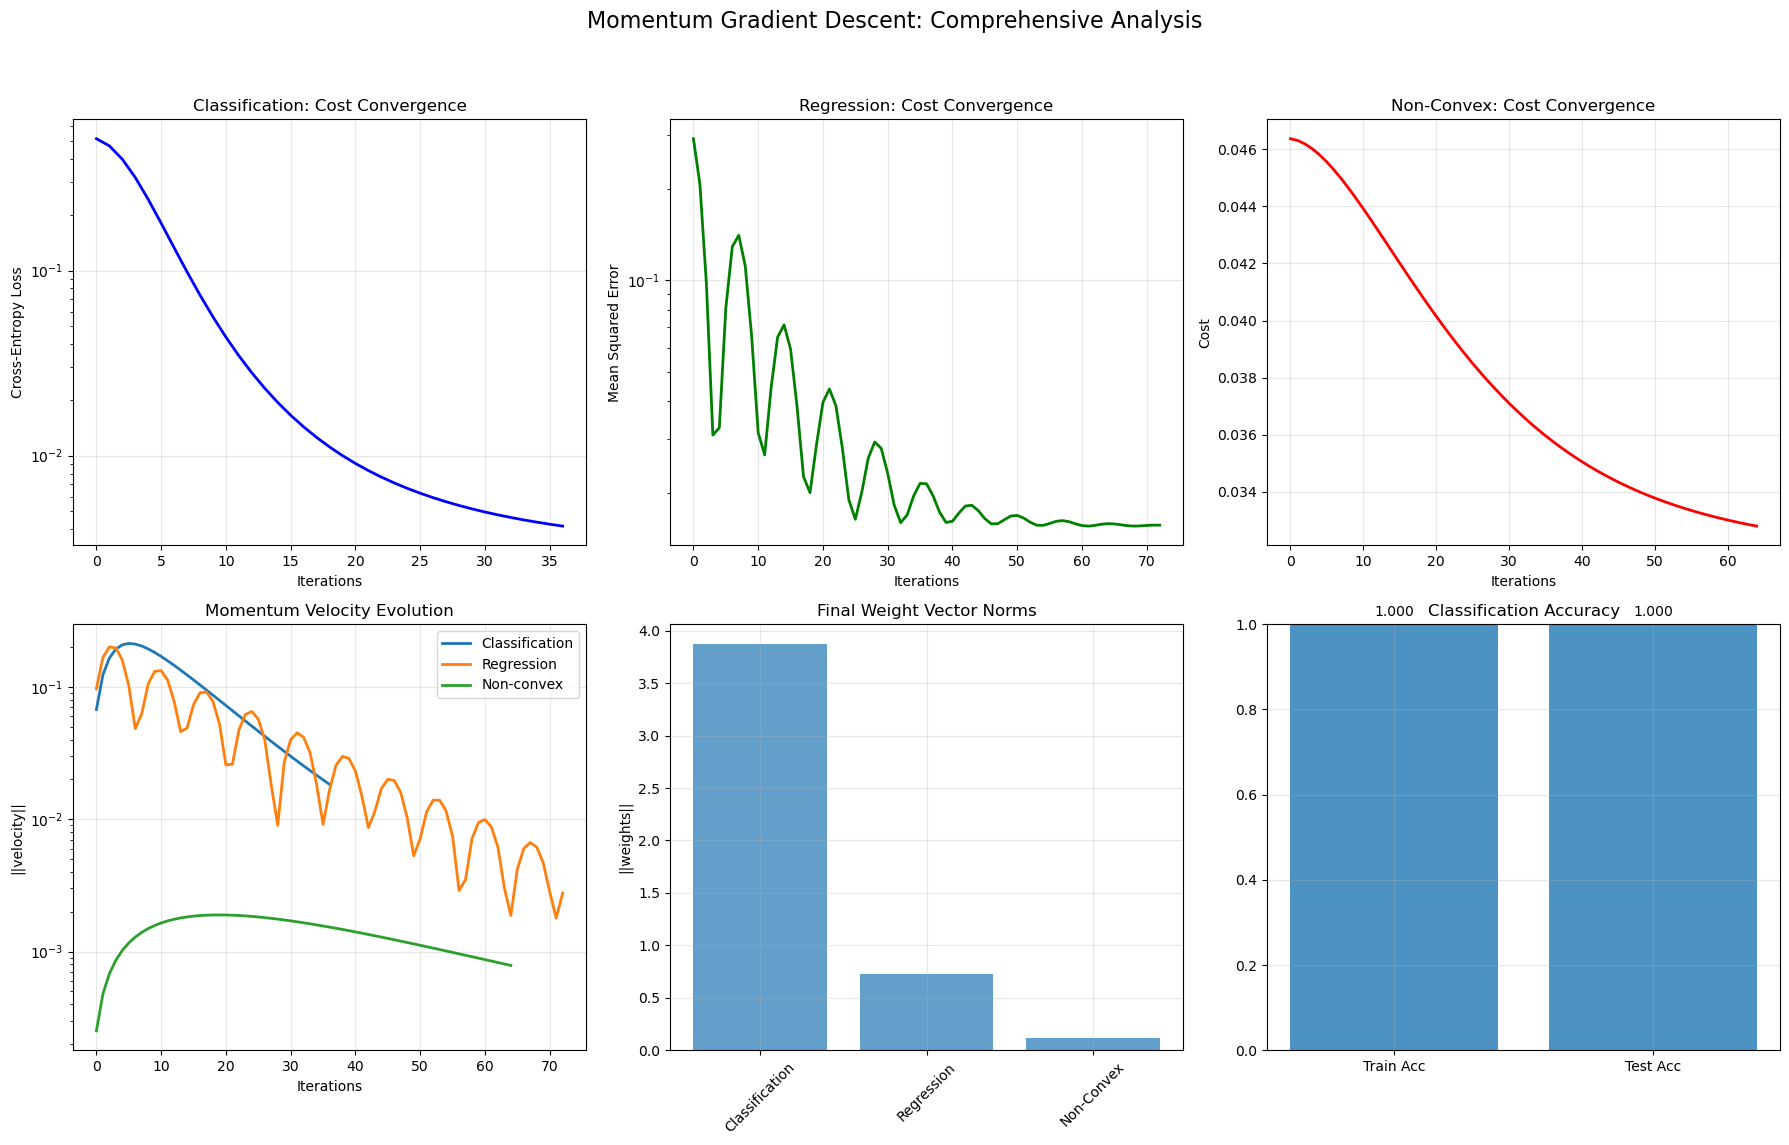


=== SUMMARY ===
Classification:
  - Train Accuracy: 1.0000, Test Accuracy: 1.0000
  - Converged: True, Iterations: 37
Regression:
  - Train MSE: 0.031176, Test MSE: 0.034174
  - Converged: True, Iterations: 73
Non-Convex:
  - Final Cost: 0.032800
  - Converged: True, Iterations: 65


In [7]:
if __name__ == "__main__":
    results = demonstrate_momentum_gradient_descent()